<a href="https://github.com/fgonzaleumbc/DATA601/tree/main/Projects/Project_1/DATA601_Project1" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
from sklearn.preprocessing import LabelEncoder
import pickle
from sklearn.pipeline import Pipeline

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

if torch.cuda.is_available():
    print('CUDA is available. Working on GPU')
    DEVICE = torch.device('cuda')
else:
    print('CUDA is not available. Working on CPU')
    DEVICE = torch.device('cpu')

CUDA is available. Working on GPU


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_img_paths = pd.read_csv('drive/MyDrive/MURA-v1.1/train_image_paths.csv', header = None, names = ['image_path'])
test_img_paths = pd.read_csv('drive/MyDrive/MURA-v1.1/valid_image_paths.csv', header = None, names = ['image_path'])

In [4]:
def split_img_paths(df):
    temp = df['image_path'].str.split('/', expand=True)
    new_df = pd.DataFrame(df['image_path'])
    new_df['patient_id'] = temp[3]
    new_df['study'] = temp[4].str.split('_', expand = True)[0].str[-1:].astype(int)
    new_df['region'] = temp[2].str.split('_', expand = True)[1]
    map = {'positive':'abnormal', 'negative':'normal'}
    new_df['target'] = temp[4].str.split('_', expand = True)[1]
    new_df['target'] = new_df['target'].map(map)
    #add google drive location to image path
    new_df['image_path'] = 'drive/MyDrive/' + new_df['image_path']
    
    return new_df

In [5]:
mura_train = split_img_paths(train_img_paths)
mura_test = split_img_paths(test_img_paths)

In [6]:
data_transforms = transforms.Compose([
    #
    #note that output channel is 1, will need to change and re-run for use with 3 channels
    #
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [7]:
def class_dict(two_targets):
    classes_2 = ['normal', 'abnormal']
    dict_2 = {'normal' : 0, 'abnormal': 1}
    
    return classes_2, dict_2

In [8]:
class MuraDataset(Dataset):
    # change two targets to False if using 14 target data
    def __init__(self, mura_df, two_targets, transform=data_transforms):
        self.mura = mura_df
        self.transform = transform
        self.classes, self.class_to_idx = class_dict(two_targets=two_targets)

    def __len__(self):
        return len(self.mura)

    # retrives image from path in df file and target from df
    def get_image_class(self, index):
        image_path = self.mura.iloc[index]['image_path']
        class_name = self.mura.iloc[index]['target']
        return Image.open(image_path), class_name  

    def __getitem__(self, idx):
        image, class_name = self.get_image_class(idx)
        label = self.class_to_idx[class_name]

        return self.transform(image), label

In [9]:
def training(model, model_name, num_epochs, train_dataloader, test_dataloader):

    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.33)

    train_loss_array = []
    train_acc_array = []
    test_loss_array = []
    test_acc_array = []
    lowest_test_loss = np.inf
    best_model = None

    for epoch in tqdm(range(num_epochs)):

        print('Epoch: {} | Learning rate: {}'.format(epoch + 1, scheduler.get_lr()))

        for phase in ['train', 'val']:

            epoch_loss = 0
            epoch_correct_items = 0
            epoch_items = 0

            if phase == 'train':
                model.train()
                with torch.enable_grad():
                    for samples, targets in train_dataloader:
                        samples = samples.to(DEVICE)
                        targets = targets.to(DEVICE)

                        optimizer.zero_grad()
                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        correct_items = (preds == targets).float().sum()
                        
                        loss.backward()
                        optimizer.step()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(targets)

                train_loss_array.append(epoch_loss / epoch_items)
                train_acc_array.append(epoch_correct_items / epoch_items)

                scheduler.step()

            elif phase == 'val':
                model.eval()
                with torch.no_grad():
                    for samples, targets in test_dataloader:
                        samples = samples.to(DEVICE)
                        targets = targets.to(DEVICE)

                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        correct_items = (preds == targets).float().sum()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(targets)

                test_loss_array.append(epoch_loss / epoch_items)
                test_acc_array.append(epoch_correct_items / epoch_items)

                if epoch_loss / epoch_items < lowest_test_loss:
                    lowest_test_loss = epoch_loss / epoch_items
                    torch.save(model.state_dict(), '{}_weights.pth'.format(model_name))
                    best_model = copy.deepcopy(model)
                    print("\t| New lowest test loss for {}: {}".format(model_name, lowest_test_loss))

    return best_model, train_loss_array, train_acc_array, test_loss_array, test_acc_array

In [10]:
def dataloader(df):
  df_dl= DataLoader(df, batch_size=64, shuffle=True)
  return df_dl

## **FOREARM**

In [ ]:
forearm_train = mura_train[mura_train['region']=='FOREARM']
forearm_test = mura_test[mura_test['region']=='FOREARM']

In [ ]:
pd.set_option('max_colwidth', None)
forearm_train.head()

,image_path,patient_id,study,region,target
29440,drive/MyDrive/MURA-v1.1/train/XR_FOREARM/patient09083/study1_positive/image1.png,patient09083,1,FOREARM,abnormal
29441,drive/MyDrive/MURA-v1.1/train/XR_FOREARM/patient09083/study1_positive/image2.png,patient09083,1,FOREARM,abnormal
29442,drive/MyDrive/MURA-v1.1/train/XR_FOREARM/patient05601/study1_positive/image1.png,patient05601,1,FOREARM,abnormal
29443,drive/MyDrive/MURA-v1.1/train/XR_FOREARM/patient05601/study1_positive/image2.png,patient05601,1,FOREARM,abnormal
29444,drive/MyDrive/MURA-v1.1/train/XR_FOREARM/patient05601/study1_positive/image3.png,patient05601,1,FOREARM,abnormal


In [ ]:
forearm_train_dataset = MuraDataset(mura_df = forearm_train, two_targets=True)
forearm_test_dataset = MuraDataset(mura_df = forearm_test, two_targets=True)

In [ ]:
Forearm_train_dataloader = dataloader(forearm_train_dataset)
Forearm_test_dataloader = dataloader(forearm_test_dataset)
num_epochs = 15

In [ ]:
model_densenet161 = models.densenet161(pretrained=True)
for param in model_densenet161.parameters():
    param.requires_grad = False
model_densenet161.classifier = torch.nn.Linear(model_densenet161.classifier.in_features, out_features=200)
model_densenet161 = model_densenet161.to(DEVICE)


densenet161_Forearm_training = training(model=model_densenet161,
                                        model_name='DenseNet161',
                                        num_epochs=num_epochs,
                                        train_dataloader=Forearm_train_dataloader,
                                        test_dataloader=Forearm_test_dataloader)

model_densenet161, train_loss_array, train_acc_array, test_loss_array, test_acc_array = densenet161_Forearm_training

forearm_min_loss = min(test_loss_array)
forearm_min_loss_epoch = test_loss_array.index(forearm_min_loss)
forearm_min_loss_accuracy = test_acc_array[forearm_min_loss_epoch]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:00<00:00, 149MB/s] 
  0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, 

Epoch: 1 | Learning rate: [0.0003]


  7%|▋         | 1/15 [24:39<5:45:17, 1479.81s/it]

	| New lowest test loss for DenseNet161: 0.014225733042555394
Epoch: 2 | Learning rate: [0.0003]


 13%|█▎        | 2/15 [25:14<2:16:28, 629.87s/it] 

	| New lowest test loss for DenseNet161: 0.011314442189428894
Epoch: 3 | Learning rate: [0.0003]


 20%|██        | 3/15 [25:49<1:11:38, 358.23s/it]

	| New lowest test loss for DenseNet161: 0.010778048505814765
Epoch: 4 | Learning rate: [3.267e-05]


 27%|██▋       | 4/15 [26:24<42:16, 230.58s/it]  

	| New lowest test loss for DenseNet161: 0.010667958132848392
Epoch: 5 | Learning rate: [9.9e-05]


 33%|███▎      | 5/15 [26:59<26:39, 159.92s/it]

Epoch: 6 | Learning rate: [9.9e-05]


 40%|████      | 6/15 [27:34<17:36, 117.41s/it]

	| New lowest test loss for DenseNet161: 0.010661371720589672
Epoch: 7 | Learning rate: [1.0781099999999999e-05]


 47%|████▋     | 7/15 [28:09<12:03, 90.44s/it] 

	| New lowest test loss for DenseNet161: 0.010460196935457248
Epoch: 8 | Learning rate: [3.267e-05]


 53%|█████▎    | 8/15 [28:43<08:27, 72.51s/it]

Epoch: 9 | Learning rate: [3.267e-05]


 60%|██████    | 9/15 [29:18<06:04, 60.79s/it]

	| New lowest test loss for DenseNet161: 0.01034326687999738
Epoch: 10 | Learning rate: [3.557763e-06]


 67%|██████▋   | 10/15 [29:52<04:23, 52.72s/it]

Epoch: 11 | Learning rate: [1.0781099999999999e-05]


 73%|███████▎  | 11/15 [30:27<03:08, 47.25s/it]

	| New lowest test loss for DenseNet161: 0.010333186962279766
Epoch: 12 | Learning rate: [1.0781099999999999e-05]


 80%|████████  | 12/15 [31:01<02:09, 43.25s/it]

Epoch: 13 | Learning rate: [1.17406179e-06]


 87%|████████▋ | 13/15 [31:35<01:20, 40.46s/it]

Epoch: 14 | Learning rate: [3.557763e-06]


 93%|█████████▎| 14/15 [32:10<00:38, 38.60s/it]

Epoch: 15 | Learning rate: [3.557763e-06]


100%|██████████| 15/15 [32:44<00:00, 130.96s/it]

	| New lowest test loss for DenseNet161: 0.010324731023604688


In [ ]:
print("\nTraining results:")
print("\tMin test loss {:.4f} was achieved during epoch #{}".format(forearm_min_loss, forearm_min_loss_epoch + 1))
print("\t test accuracy during min test loss is {:.4f}".format(forearm_min_loss_accuracy))


Training results:
	Min test loss 0.0103 was achieved during epoch #15
	 test accuracy during min test loss is 0.6545


In [ ]:
#predictions on Test data

all_preds = []
all_files = []

model_densenet161.eval()
with torch.no_grad():
    for samples, f_names in tqdm(Forearm_test_dataloader):
        samples = samples.to(DEVICE)
        outputs = model_densenet161(samples)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.tolist())
        all_files.extend(f_names)

all_filenames= forearm_test['image_path'].values.tolist()

def class_dict_inverse(two_targets):
    if two_targets==0:
      return 'normal'
    else:
      return 'abnormal'

all_preds_decoded = [class_dict_inverse(i) for i in all_preds]

submission_forearm_df = pd.DataFrame(list(zip(all_filenames, all_preds_decoded)), columns =['File', 'Prediction'])
submission_forearm_df.to_csv('test_predictions_forearm.csv', header=False, index=False) 
submission_forearm_df.head(10)

100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


,File,Prediction
0,drive/MyDrive/MURA-v1.1/valid/XR_FOREARM/patient11392/study1_positive/image1.png,abnormal
1,drive/MyDrive/MURA-v1.1/valid/XR_FOREARM/patient11392/study1_positive/image2.png,normal
2,drive/MyDrive/MURA-v1.1/valid/XR_FOREARM/patient11392/study1_positive/image3.png,normal
3,drive/MyDrive/MURA-v1.1/valid/XR_FOREARM/patient11393/study1_positive/image1.png,normal
4,drive/MyDrive/MURA-v1.1/valid/XR_FOREARM/patient11393/study1_positive/image2.png,normal
5,drive/MyDrive/MURA-v1.1/valid/XR_FOREARM/patient11394/study1_positive/image1.png,normal
6,drive/MyDrive/MURA-v1.1/valid/XR_FOREARM/patient11394/study1_positive/image2.png,normal
7,drive/MyDrive/MURA-v1.1/valid/XR_FOREARM/patient11395/study1_positive/image1.png,normal
8,drive/MyDrive/MURA-v1.1/valid/XR_FOREARM/patient11395/study1_positive/image2.png,abnormal
9,drive/MyDrive/MURA-v1.1/valid/XR_FOREARM/patient11396/study1_positive/image1.png,normal


In [ ]:
# loading saved model and load state dict

loaded_model = models.densenet161(pretrained=True)
for param in loaded_model.parameters():
    param.requires_grad = False
loaded_model.classifier = torch.nn.Linear(loaded_model.classifier.in_features, out_features=200)
loaded_model.load_state_dict(torch.load("DenseNet161_weights.pth")) 
loaded_model.to('cpu')


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

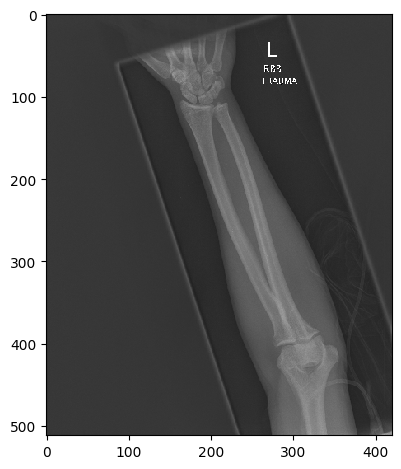

In [ ]:
# Just look at image
from skimage import io

io.imshow('image1.png')

In [ ]:
# read image and transform

from PIL import Image

img_pil = Image.open('image1.png')

img_trans = data_transforms(img_pil)
img_trans.to('cpu')
img_trans.shape

torch.Size([3, 224, 224])

In [ ]:
# make shape of model input

img_trans = img_trans.unsqueeze(0)
img_trans.shape

torch.Size([1, 3, 224, 224])

In [ ]:
# get prediction
y_pred = loaded_model(img_trans)
prediction = torch.argmax(y_pred, 1)
prediction.item()


0

## **HAND**

In [ ]:
hand_train = mura_train[mura_train['region']=='HAND']
hand_test = mura_test[mura_test['region']=='HAND']

In [ ]:
hand_train_dataset = MuraDataset(mura_df = hand_train, two_targets=True)
hand_test_dataset = MuraDataset(mura_df = hand_test, two_targets=True)

In [ ]:
hand_train_dataloader = dataloader(hand_train_dataset)
hand_test_dataloader = dataloader(hand_test_dataset)
num_epochs = 15

In [ ]:
model_densenet161 = models.densenet161(pretrained=True)
for param in model_densenet161.parameters():
    param.requires_grad = False
model_densenet161.classifier = torch.nn.Linear(model_densenet161.classifier.in_features, out_features=200)
model_densenet161 = model_densenet161.to(DEVICE)


densenet161_hand_training = training(model=model_densenet161,
                                        model_name='DenseNet161',
                                        num_epochs=num_epochs,
                                        train_dataloader=hand_train_dataloader,
                                        test_dataloader=hand_test_dataloader)

model_densenet161, train_loss_array, train_acc_array, test_loss_array, test_acc_array = densenet161_hand_training

hand_min_loss = min(test_loss_array)
hand_min_loss_epoch = test_loss_array.index(hand_min_loss)
hand_min_loss_accuracy = test_acc_array[hand_min_loss_epoch]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: 1 | Learning rate: [0.0003]


  7%|▋         | 1/15 [1:15:02<17:30:35, 4502.50s/it]

	| New lowest test loss for DenseNet161: 0.012063316936078278
Epoch: 2 | Learning rate: [0.0003]


 13%|█▎        | 2/15 [1:16:36<6:53:43, 1909.46s/it] 

	| New lowest test loss for DenseNet161: 0.011165187410686327
Epoch: 3 | Learning rate: [0.0003]


 20%|██        | 3/15 [1:18:10<3:36:06, 1080.52s/it]

	| New lowest test loss for DenseNet161: 0.010974967609281126
Epoch: 4 | Learning rate: [3.267e-05]


 27%|██▋       | 4/15 [1:19:44<2:06:40, 690.93s/it] 

Epoch: 5 | Learning rate: [9.9e-05]


 33%|███▎      | 5/15 [1:21:17<1:19:14, 475.44s/it]

	| New lowest test loss for DenseNet161: 0.010497188762478207
Epoch: 6 | Learning rate: [9.9e-05]


 40%|████      | 6/15 [1:22:52<51:54, 346.01s/it]  

	| New lowest test loss for DenseNet161: 0.010077027069485706
Epoch: 7 | Learning rate: [1.0781099999999999e-05]


 47%|████▋     | 7/15 [1:24:26<35:08, 263.56s/it]

Epoch: 8 | Learning rate: [3.267e-05]


 53%|█████▎    | 8/15 [1:26:00<24:26, 209.43s/it]

Epoch: 9 | Learning rate: [3.267e-05]


 60%|██████    | 9/15 [1:27:33<17:19, 173.25s/it]

Epoch: 10 | Learning rate: [3.557763e-06]


 67%|██████▋   | 10/15 [1:29:07<12:23, 148.78s/it]

Epoch: 11 | Learning rate: [1.0781099999999999e-05]


 73%|███████▎  | 11/15 [1:30:41<08:47, 131.79s/it]

Epoch: 12 | Learning rate: [1.0781099999999999e-05]


 80%|████████  | 12/15 [1:32:14<06:00, 120.11s/it]

Epoch: 13 | Learning rate: [1.17406179e-06]


 87%|████████▋ | 13/15 [1:33:48<03:44, 112.11s/it]

Epoch: 14 | Learning rate: [3.557763e-06]


 93%|█████████▎| 14/15 [1:35:22<01:46, 106.72s/it]

Epoch: 15 | Learning rate: [3.557763e-06]


100%|██████████| 15/15 [1:36:56<00:00, 387.74s/it]


In [ ]:
print("\nTraining results:")
print("\tMin test loss {:.4f} was achieved during epoch #{}".format(hand_min_loss, hand_min_loss_epoch + 1))
print("\t test accuracy during min test loss is {:.4f}".format(hand_min_loss_accuracy))


Training results:
	Min test loss 0.0101 was achieved during epoch #6
	 test accuracy during min test loss is 0.6522


In [ ]:
loaded_model = models.densenet161(pretrained=True)
for param in loaded_model.parameters():
    param.requires_grad = False
loaded_model.classifier = torch.nn.Linear(loaded_model.classifier.in_features, out_features=200)
loaded_model.load_state_dict(torch.load("DenseNet161_weights.pth")) 
loaded_model.to('cpu')

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

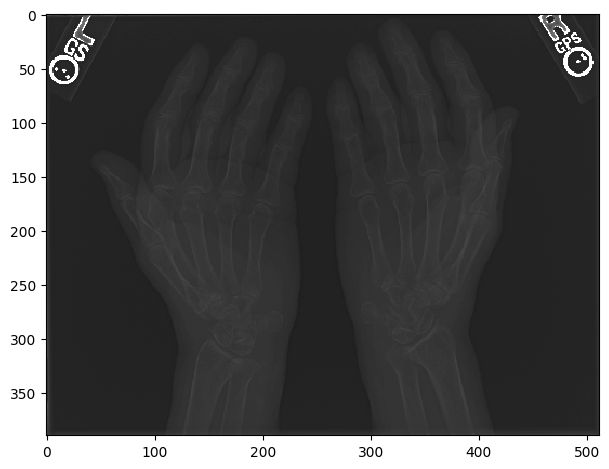

In [ ]:
from skimage import io

io.imshow('image2.png')

In [ ]:
from PIL import Image

img_pil = Image.open('image2.png')

img_trans = data_transforms(img_pil)
img_trans.to('cpu')
img_trans.shape

torch.Size([3, 224, 224])

In [ ]:
img_trans = img_trans.unsqueeze(0)
img_trans.shape

torch.Size([1, 3, 224, 224])

In [ ]:
y_pred = loaded_model(img_trans)
prediction = torch.argmax(y_pred, 1)
prediction.item()

0

## **HUMERUS**

In [11]:
humerus_train = mura_train[mura_train['region']=='HUMERUS']
humerus_test = mura_test[mura_test['region']=='HUMERUS']

In [12]:
humerus_train_dataset = MuraDataset(mura_df = humerus_train, two_targets=True)
humerus_test_dataset = MuraDataset(mura_df = humerus_test, two_targets=True)

In [16]:
Humerus_train_dataloader = dataloader(humerus_train_dataset)
Humerus_test_dataloader = dataloader(humerus_test_dataset)
num_epochs = 15

In [17]:
model_densenet161 = models.densenet161(pretrained=True)
for param in model_densenet161.parameters():
    param.requires_grad = False
model_densenet161.classifier = torch.nn.Linear(model_densenet161.classifier.in_features, out_features=200)
model_densenet161 = model_densenet161.to(DEVICE)


densenet161_humerus_training = training(model=model_densenet161,
                                        model_name='DenseNet161',
                                        num_epochs=num_epochs,
                                        train_dataloader=Humerus_train_dataloader,
                                        test_dataloader=Humerus_test_dataloader)

model_densenet161, train_loss_array, train_acc_array, test_loss_array, test_acc_array = densenet161_humerus_training

humerus_min_loss = min(test_loss_array)
humerus_min_loss_epoch = test_loss_array.index(humerus_min_loss)
humerus_min_loss_accuracy = test_acc_array[humerus_min_loss_epoch]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]


  7%|▋         | 1/15 [00:25<06:00, 25.77s/it]

	| New lowest test loss for DenseNet161: 0.02185092866420746
Epoch: 2 | Learning rate: [0.0003]


 13%|█▎        | 2/15 [00:51<05:31, 25.49s/it]

	| New lowest test loss for DenseNet161: 0.012826587383945784
Epoch: 3 | Learning rate: [0.0003]


 20%|██        | 3/15 [01:16<05:02, 25.24s/it]

	| New lowest test loss for DenseNet161: 0.011793997759620348
Epoch: 4 | Learning rate: [3.267e-05]


 27%|██▋       | 4/15 [01:40<04:35, 25.08s/it]

	| New lowest test loss for DenseNet161: 0.01147524557179875
Epoch: 5 | Learning rate: [9.9e-05]


 33%|███▎      | 5/15 [02:05<04:10, 25.10s/it]

	| New lowest test loss for DenseNet161: 0.011183108099632792
Epoch: 6 | Learning rate: [9.9e-05]


 40%|████      | 6/15 [02:31<03:46, 25.11s/it]

	| New lowest test loss for DenseNet161: 0.01099049486219883
Epoch: 7 | Learning rate: [1.0781099999999999e-05]


 47%|████▋     | 7/15 [02:55<03:19, 24.88s/it]

Epoch: 8 | Learning rate: [3.267e-05]


 53%|█████▎    | 8/15 [03:20<02:55, 25.01s/it]

	| New lowest test loss for DenseNet161: 0.01087981772919496
Epoch: 9 | Learning rate: [3.267e-05]


 60%|██████    | 9/15 [03:45<02:29, 25.00s/it]

	| New lowest test loss for DenseNet161: 0.010842111168636216
Epoch: 10 | Learning rate: [3.557763e-06]


 67%|██████▋   | 10/15 [04:10<02:05, 25.04s/it]

	| New lowest test loss for DenseNet161: 0.010761215248041682
Epoch: 11 | Learning rate: [1.0781099999999999e-05]


 73%|███████▎  | 11/15 [04:35<01:39, 24.86s/it]

Epoch: 12 | Learning rate: [1.0781099999999999e-05]


 80%|████████  | 12/15 [04:59<01:14, 24.69s/it]

Epoch: 13 | Learning rate: [1.17406179e-06]


 87%|████████▋ | 13/15 [05:24<00:49, 24.74s/it]

	| New lowest test loss for DenseNet161: 0.01071557713051637
Epoch: 14 | Learning rate: [3.557763e-06]


 93%|█████████▎| 14/15 [05:49<00:24, 24.74s/it]

Epoch: 15 | Learning rate: [3.557763e-06]


100%|██████████| 15/15 [06:13<00:00, 24.92s/it]


In [18]:
print("\nTraining results:")
print("\tMin test loss {:.4f} was achieved during epoch #{}".format(humerus_min_loss, humerus_min_loss_epoch + 1))
print("\t test accuracy during min test loss is {:.4f}".format(humerus_min_loss_accuracy))


Training results:
	Min test loss 0.0107 was achieved during epoch #13
	 test accuracy during min test loss is 0.6875


# **ELBOW**

In [19]:
elbow_train = mura_train[mura_train['region']=='ELBOW']
elbow_test = mura_test[mura_test['region']=='ELBOW']

In [20]:
elbow_train_dataset = MuraDataset(mura_df = elbow_train, two_targets=True)
elbow_test_dataset = MuraDataset(mura_df = elbow_test, two_targets=True)

In [21]:
Elbow_train_dataloader = dataloader(elbow_train_dataset)
Elbow_test_dataloader = dataloader(elbow_test_dataset)
num_epochs = 15

In [22]:
model_densenet161 = models.densenet161(pretrained=True)
for param in model_densenet161.parameters():
    param.requires_grad = False
model_densenet161.classifier = torch.nn.Linear(model_densenet161.classifier.in_features, out_features=200)
model_densenet161 = model_densenet161.to(DEVICE)


densenet161_elbow_training = training(model=model_densenet161,
                                        model_name='DenseNet161',
                                        num_epochs=num_epochs,
                                        train_dataloader=Elbow_train_dataloader,
                                        test_dataloader=Elbow_test_dataloader)

model_densenet161, train_loss_array, train_acc_array, test_loss_array, test_acc_array = densenet161_elbow_training

elbow_min_loss = min(test_loss_array)
elbow_min_loss_epoch = test_loss_array.index(elbow_min_loss)
elbow_min_loss_accuracy = test_acc_array[elbow_min_loss_epoch]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]


  7%|▋         | 1/15 [31:30<7:21:11, 1890.81s/it]

	| New lowest test loss for DenseNet161: 0.01177840732759045
Epoch: 2 | Learning rate: [0.0003]


 13%|█▎        | 2/15 [32:55<2:59:29, 828.40s/it] 

	| New lowest test loss for DenseNet161: 0.010650051537380424
Epoch: 3 | Learning rate: [0.0003]


 20%|██        | 3/15 [34:20<1:37:46, 488.91s/it]

	| New lowest test loss for DenseNet161: 0.00983322653719174
Epoch: 4 | Learning rate: [3.267e-05]


 27%|██▋       | 4/15 [35:44<1:00:21, 329.26s/it]

	| New lowest test loss for DenseNet161: 0.009459365696035405
Epoch: 5 | Learning rate: [9.9e-05]


 33%|███▎      | 5/15 [37:09<40:10, 241.03s/it]  

	| New lowest test loss for DenseNet161: 0.009291055125574911
Epoch: 6 | Learning rate: [9.9e-05]


 40%|████      | 6/15 [38:33<28:08, 187.56s/it]

Epoch: 7 | Learning rate: [1.0781099999999999e-05]


 47%|████▋     | 7/15 [39:56<20:28, 153.59s/it]

	| New lowest test loss for DenseNet161: 0.009251457773229128
Epoch: 8 | Learning rate: [3.267e-05]


 53%|█████▎    | 8/15 [41:20<15:17, 131.14s/it]

Epoch: 9 | Learning rate: [3.267e-05]


 60%|██████    | 9/15 [42:43<11:37, 116.21s/it]

	| New lowest test loss for DenseNet161: 0.008995338024631623
Epoch: 10 | Learning rate: [3.557763e-06]


 67%|██████▋   | 10/15 [44:07<08:51, 106.23s/it]

Epoch: 11 | Learning rate: [1.0781099999999999e-05]


 73%|███████▎  | 11/15 [45:30<06:37, 99.31s/it] 

Epoch: 12 | Learning rate: [1.0781099999999999e-05]


 80%|████████  | 12/15 [46:54<04:43, 94.63s/it]

	| New lowest test loss for DenseNet161: 0.008905249577696605
Epoch: 13 | Learning rate: [1.17406179e-06]


 87%|████████▋ | 13/15 [48:18<03:02, 91.44s/it]

Epoch: 14 | Learning rate: [3.557763e-06]


 93%|█████████▎| 14/15 [49:42<01:29, 89.06s/it]

Epoch: 15 | Learning rate: [3.557763e-06]


100%|██████████| 15/15 [51:05<00:00, 204.40s/it]


In [23]:
print("\nTraining results:")
print("\tMin test loss {:.4f} was achieved during epoch #{}".format(elbow_min_loss, elbow_min_loss_epoch + 1))
print("\t test accuracy during min test loss is {:.4f}".format(elbow_min_loss_accuracy))


Training results:
	Min test loss 0.0089 was achieved during epoch #12
	 test accuracy during min test loss is 0.7333


## **SHOULDER**

In [24]:
shoulder_train = mura_train[mura_train['region']=='SHOULDER']
shoulder_test = mura_test[mura_test['region']=='SHOULDER']


In [25]:
shoulder_train_dataset = MuraDataset(mura_df = shoulder_train, two_targets=True)
shoulder_test_dataset = MuraDataset(mura_df = shoulder_test, two_targets=True)

In [26]:
Shoulder_train_dataloader = dataloader(shoulder_train_dataset)
Shoulder_test_dataloader = dataloader(shoulder_test_dataset)
num_epochs = 15

In [30]:
model_densenet161 = models.densenet161(pretrained=True)
for param in model_densenet161.parameters():
    param.requires_grad = False
model_densenet161.classifier = torch.nn.Linear(model_densenet161.classifier.in_features, out_features=200)
model_densenet161 = model_densenet161.to(DEVICE)


densenet161_shoulder_training = training(model=model_densenet161,
                                        model_name='DenseNet161',
                                        num_epochs=num_epochs,
                                        train_dataloader=Shoulder_train_dataloader,
                                        test_dataloader=Shoulder_test_dataloader)

model_densenet161, train_loss_array, train_acc_array, test_loss_array, test_acc_array = densenet161_shoulder_training

shoulder_min_loss = min(test_loss_array)
shoulder_min_loss_epoch = test_loss_array.index(shoulder_min_loss)
shoulder_min_loss_accuracy = test_acc_array[shoulder_min_loss_epoch]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]


  7%|▋         | 1/15 [02:19<32:35, 139.70s/it]

	| New lowest test loss for DenseNet161: 0.010360082449328624
Epoch: 2 | Learning rate: [0.0003]


 13%|█▎        | 2/15 [04:40<30:23, 140.24s/it]

	| New lowest test loss for DenseNet161: 0.009710979080538978
Epoch: 3 | Learning rate: [0.0003]


 20%|██        | 3/15 [07:04<28:22, 141.89s/it]

	| New lowest test loss for DenseNet161: 0.009230584700196505
Epoch: 4 | Learning rate: [3.267e-05]


 27%|██▋       | 4/15 [09:25<25:58, 141.70s/it]

	| New lowest test loss for DenseNet161: 0.009120021683708178
Epoch: 5 | Learning rate: [9.9e-05]


 33%|███▎      | 5/15 [11:46<23:34, 141.41s/it]

	| New lowest test loss for DenseNet161: 0.009051000140276514
Epoch: 6 | Learning rate: [9.9e-05]


 40%|████      | 6/15 [14:11<21:23, 142.57s/it]

	| New lowest test loss for DenseNet161: 0.008947559508294872
Epoch: 7 | Learning rate: [1.0781099999999999e-05]


 47%|████▋     | 7/15 [16:37<19:10, 143.82s/it]

	| New lowest test loss for DenseNet161: 0.0089432867128091
Epoch: 8 | Learning rate: [3.267e-05]


 53%|█████▎    | 8/15 [19:05<16:56, 145.20s/it]

Epoch: 9 | Learning rate: [3.267e-05]


 60%|██████    | 9/15 [21:34<14:37, 146.22s/it]

	| New lowest test loss for DenseNet161: 0.00888321793524029
Epoch: 10 | Learning rate: [3.557763e-06]


 67%|██████▋   | 10/15 [24:01<12:11, 146.37s/it]

Epoch: 11 | Learning rate: [1.0781099999999999e-05]


 73%|███████▎  | 11/15 [26:27<09:45, 146.49s/it]

	| New lowest test loss for DenseNet161: 0.008876085069632658
Epoch: 12 | Learning rate: [1.0781099999999999e-05]


 80%|████████  | 12/15 [28:55<07:20, 146.87s/it]

	| New lowest test loss for DenseNet161: 0.00886982965215273
Epoch: 13 | Learning rate: [1.17406179e-06]


 87%|████████▋ | 13/15 [31:22<04:53, 146.80s/it]

	| New lowest test loss for DenseNet161: 0.008854212335329072
Epoch: 14 | Learning rate: [3.557763e-06]


 93%|█████████▎| 14/15 [33:48<02:26, 146.71s/it]

	| New lowest test loss for DenseNet161: 0.008851248671699374
Epoch: 15 | Learning rate: [3.557763e-06]


100%|██████████| 15/15 [36:13<00:00, 144.91s/it]

	| New lowest test loss for DenseNet161: 0.008850007084716066


In [31]:
print("\nTraining results:")
print("\tMin test loss {:.4f} was achieved during epoch #{}".format(shoulder_min_loss, shoulder_min_loss_epoch + 1))
print("\t test accuracy during min test loss is {:.4f}".format(shoulder_min_loss_accuracy))


Training results:
	Min test loss 0.0089 was achieved during epoch #15
	 test accuracy during min test loss is 0.7300


## **FINGER**

In [32]:
finger_train = mura_train[mura_train['region']=='FINGER']
finger_test = mura_test[mura_test['region']=='FINGER']


In [33]:
finger_train_dataset = MuraDataset(mura_df = finger_train, two_targets=True)
finger_test_dataset = MuraDataset(mura_df = finger_test, two_targets=True)

In [34]:
Finger_train_dataloader = dataloader(finger_train_dataset)
Finger_test_dataloader = dataloader(finger_test_dataset)
num_epochs = 15

In [35]:
model_densenet161 = models.densenet161(pretrained=True)
for param in model_densenet161.parameters():
    param.requires_grad = False
model_densenet161.classifier = torch.nn.Linear(model_densenet161.classifier.in_features, out_features=200)
model_densenet161 = model_densenet161.to(DEVICE)


densenet161_finger_training = training(model=model_densenet161,
                                        model_name='DenseNet161',
                                        num_epochs=num_epochs,
                                        train_dataloader=Finger_train_dataloader,
                                        test_dataloader=Finger_test_dataloader)

model_densenet161, train_loss_array, train_acc_array, test_loss_array, test_acc_array = densenet161_finger_training

finger_min_loss = min(test_loss_array)
finger_min_loss_epoch = test_loss_array.index(finger_min_loss)
finger_min_loss_accuracy = test_acc_array[finger_min_loss_epoch]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]


  7%|▋         | 1/15 [34:08<7:57:59, 2048.52s/it]

	| New lowest test loss for DenseNet161: 0.011712935379425513
Epoch: 2 | Learning rate: [0.0003]


 13%|█▎        | 2/15 [35:34<3:13:39, 893.81s/it] 

	| New lowest test loss for DenseNet161: 0.01124563923109638
Epoch: 3 | Learning rate: [0.0003]


 20%|██        | 3/15 [36:58<1:44:52, 524.34s/it]

Epoch: 4 | Learning rate: [3.267e-05]


 27%|██▋       | 4/15 [38:23<1:04:18, 350.81s/it]

	| New lowest test loss for DenseNet161: 0.010962628232165686
Epoch: 5 | Learning rate: [9.9e-05]


 33%|███▎      | 5/15 [39:49<42:33, 255.30s/it]  

	| New lowest test loss for DenseNet161: 0.010767143874261488
Epoch: 6 | Learning rate: [9.9e-05]


 40%|████      | 6/15 [41:15<29:41, 197.89s/it]

	| New lowest test loss for DenseNet161: 0.010253449970626003
Epoch: 7 | Learning rate: [1.0781099999999999e-05]


 47%|████▋     | 7/15 [42:40<21:27, 160.99s/it]

Epoch: 8 | Learning rate: [3.267e-05]


 53%|█████▎    | 8/15 [44:07<16:00, 137.24s/it]

Epoch: 9 | Learning rate: [3.267e-05]


 60%|██████    | 9/15 [45:33<12:08, 121.41s/it]

Epoch: 10 | Learning rate: [3.557763e-06]


 67%|██████▋   | 10/15 [47:01<09:14, 110.99s/it]

	| New lowest test loss for DenseNet161: 0.010247916823612636
Epoch: 11 | Learning rate: [1.0781099999999999e-05]


 73%|███████▎  | 11/15 [48:29<06:55, 103.80s/it]

Epoch: 12 | Learning rate: [1.0781099999999999e-05]


 80%|████████  | 12/15 [49:55<04:56, 98.67s/it] 

	| New lowest test loss for DenseNet161: 0.00983981894826165
Epoch: 13 | Learning rate: [1.17406179e-06]


 87%|████████▋ | 13/15 [51:22<03:10, 95.10s/it]

Epoch: 14 | Learning rate: [3.557763e-06]


 93%|█████████▎| 14/15 [52:49<01:32, 92.42s/it]

Epoch: 15 | Learning rate: [3.557763e-06]


100%|██████████| 15/15 [54:16<00:00, 217.07s/it]


In [36]:
print("\nTraining results:")
print("\tMin test loss {:.4f} was achieved during epoch #{}".format(finger_min_loss, finger_min_loss_epoch + 1))
print("\t test accuracy during min test loss is {:.4f}".format(finger_min_loss_accuracy))


Training results:
	Min test loss 0.0098 was achieved during epoch #12
	 test accuracy during min test loss is 0.6811


## **WRIST**

In [37]:
wrist_train = mura_train[mura_train['region']=='WRIST']
wrist_test = mura_test[mura_test['region']=='WRIST']

In [38]:
wrist_train_dataset = MuraDataset(mura_df = wrist_train, two_targets=True)
wrist_test_dataset = MuraDataset(mura_df = wrist_test, two_targets=True)

In [39]:
Wrist_train_dataloader = DataLoader(wrist_train_dataset, batch_size=64, shuffle=True)
Wrist_test_dataloader = DataLoader(wrist_test_dataset, batch_size=64, shuffle=False)
num_epochs = 15

In [41]:
model_densenet161 = models.densenet161(pretrained=True)
for param in model_densenet161.parameters():
    param.requires_grad = False
model_densenet161.classifier = torch.nn.Linear(model_densenet161.classifier.in_features, out_features=200)
model_densenet161 = model_densenet161.to(DEVICE)

densenet161_Wrist_training = training(model=model_densenet161,
                                        model_name='DenseNet161',
                                        num_epochs=num_epochs,
                                        train_dataloader=Wrist_train_dataloader,
                                        test_dataloader=Wrist_test_dataloader)

model_densenet161, train_loss_array, train_acc_array, test_loss_array, test_acc_array = densenet161_Wrist_training

wrist_min_loss = min(test_loss_array)
wrist_min_loss_epoch = test_loss_array.index(wrist_min_loss)
wrist_min_loss_accuracy = test_acc_array[wrist_min_loss_epoch]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]


  7%|▋         | 1/15 [02:38<36:53, 158.11s/it]

	| New lowest test loss for DenseNet161: 0.009733337371953522
Epoch: 2 | Learning rate: [0.0003]


 13%|█▎        | 2/15 [05:15<34:13, 157.97s/it]

	| New lowest test loss for DenseNet161: 0.008757645063588398
Epoch: 3 | Learning rate: [0.0003]


 20%|██        | 3/15 [07:54<31:38, 158.21s/it]

	| New lowest test loss for DenseNet161: 0.008457039303410577
Epoch: 4 | Learning rate: [3.267e-05]


 27%|██▋       | 4/15 [10:32<29:00, 158.18s/it]

	| New lowest test loss for DenseNet161: 0.008266972007628456
Epoch: 5 | Learning rate: [9.9e-05]


 33%|███▎      | 5/15 [13:14<26:33, 159.35s/it]

	| New lowest test loss for DenseNet161: 0.008192154995769217
Epoch: 6 | Learning rate: [9.9e-05]


 40%|████      | 6/15 [15:54<23:56, 159.66s/it]

Epoch: 7 | Learning rate: [1.0781099999999999e-05]


 47%|████▋     | 7/15 [18:33<21:15, 159.43s/it]

	| New lowest test loss for DenseNet161: 0.008100536890746248
Epoch: 8 | Learning rate: [3.267e-05]


 53%|█████▎    | 8/15 [21:12<18:35, 159.38s/it]

	| New lowest test loss for DenseNet161: 0.008097503136430779
Epoch: 9 | Learning rate: [3.267e-05]


 60%|██████    | 9/15 [23:53<15:58, 159.76s/it]

	| New lowest test loss for DenseNet161: 0.008030178876132993
Epoch: 10 | Learning rate: [3.557763e-06]


 67%|██████▋   | 10/15 [26:33<13:20, 160.07s/it]

Epoch: 11 | Learning rate: [1.0781099999999999e-05]


 73%|███████▎  | 11/15 [29:12<10:38, 159.69s/it]

Epoch: 12 | Learning rate: [1.0781099999999999e-05]


 80%|████████  | 12/15 [31:52<07:58, 159.59s/it]

Epoch: 13 | Learning rate: [1.17406179e-06]


 87%|████████▋ | 13/15 [34:30<05:18, 159.23s/it]

Epoch: 14 | Learning rate: [3.557763e-06]


 93%|█████████▎| 14/15 [37:11<02:39, 159.82s/it]

Epoch: 15 | Learning rate: [3.557763e-06]


100%|██████████| 15/15 [39:51<00:00, 159.41s/it]


In [42]:
print("\nTraining results:")
print("\tMin test loss {:.4f} was achieved during epoch #{}".format(wrist_min_loss, wrist_min_loss_epoch + 1))
print("\t test accuracy during min test loss is {:.4f}".format(wrist_min_loss_accuracy))


Training results:
	Min test loss 0.0080 was achieved during epoch #9
	 test accuracy during min test loss is 0.7663
